In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import seaborn as sns
import os


In [2]:
# Load Data
df = pd.read_csv("Final.csv") 

print("Preview of data:")
print(df.head())


Preview of data:
    Country     Region        Date   AQI  Temperature  RelativeHumidity  \
0  Malaysia  AlorSetar  2014-01-01  34.0        26.11             76.95   
1  Malaysia  AlorSetar  2014-01-02  30.0        26.48             77.45   
2  Malaysia  AlorSetar  2014-01-03  28.0        26.40             78.64   
3  Malaysia  AlorSetar  2014-01-04  32.0        26.38             79.88   
4  Malaysia  AlorSetar  2014-01-05  37.0        26.32             77.90   

   WindSpeed  
0      21.52  
1      20.62  
2      17.37  
3      15.41  
4      14.90  


In [3]:
#Clean Missing Value
print("\nMissing values before cleaning:\n", df.isnull().sum())

# Convert to numeric
for col in ['AQI', 'Temperature', 'RelativeHumidity', 'WindSpeed']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


# Fill missing AQI with mean
df['AQI'] = df['AQI'].fillna(df['AQI'].mean())

print("\nMissing values after cleaning:\n", df.isnull().sum())


Missing values before cleaning:
 Country             0
Region              0
Date                0
AQI                 0
Temperature         0
RelativeHumidity    0
WindSpeed           0
dtype: int64

Missing values after cleaning:
 Country             0
Region              0
Date                0
AQI                 0
Temperature         0
RelativeHumidity    0
WindSpeed           0
dtype: int64



K-Means Clustering for: Malaysia


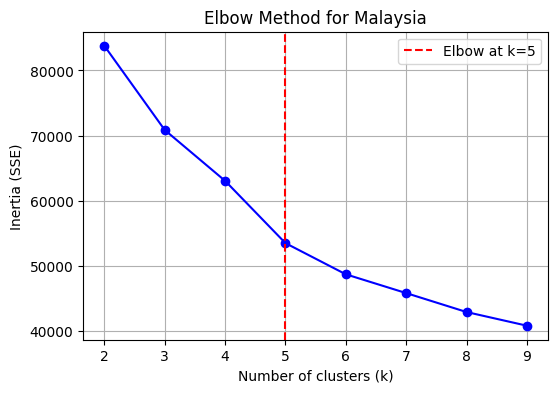


Final Silhouette Score for Malaysia: 0.220
Inertia (SSE): 53468.70
Largest cluster size ratio: 28.42%

Cluster counts:
Cluster
3    8331
4    8028
1    6266
0    3989
2    2702
Name: count, dtype: int64

Average values per cluster:
               AQI  Temperature  RelativeHumidity  WindSpeed
Cluster                                                     
0        37.743273    25.998606         85.264091  16.710975
1        28.663581    26.977873         84.736521  10.246230
2        52.413338    28.123449         71.895888  15.204756
3        35.793447    25.615658         90.193776   9.481546
4        62.606867    26.880166         84.248414  10.919189


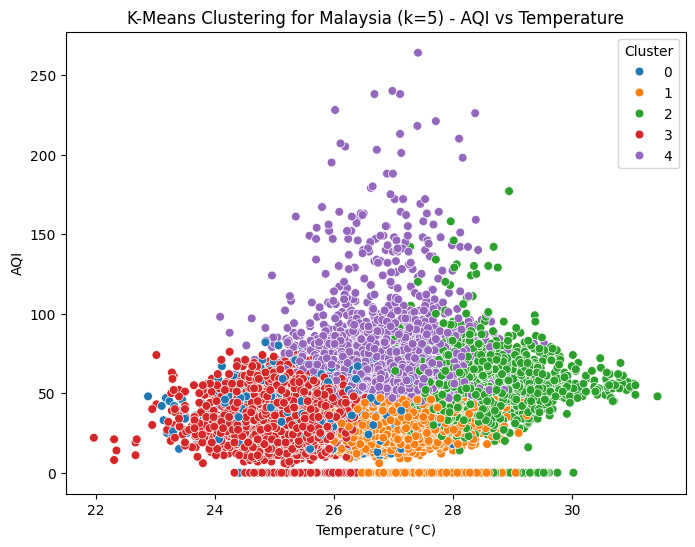


K-Means Clustering for: Singapore


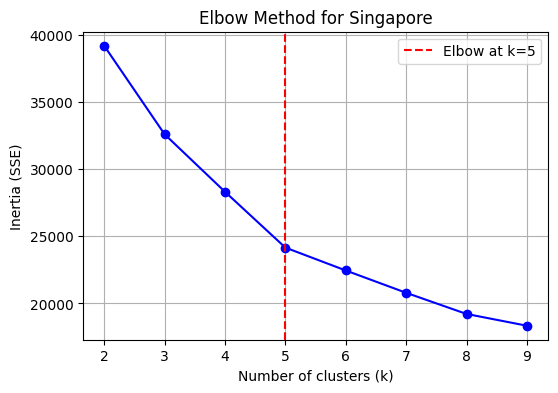


Final Silhouette Score for Singapore: 0.236
Inertia (SSE): 24162.04
Largest cluster size ratio: 26.91%

Cluster counts:
Cluster
0    3743
4    3690
3    2839
1    2140
2    1496
Name: count, dtype: int64

Average values per cluster:
               AQI  Temperature  RelativeHumidity  WindSpeed
Cluster                                                     
0        52.792407    27.639842         82.460059   4.254045
1        34.663827    26.444776         86.914327   4.436953
2        49.280775    27.841745         78.747119   9.663770
3        35.147034    28.543100         77.515368   4.572673
4        56.308967    29.083322         74.128019   4.977173


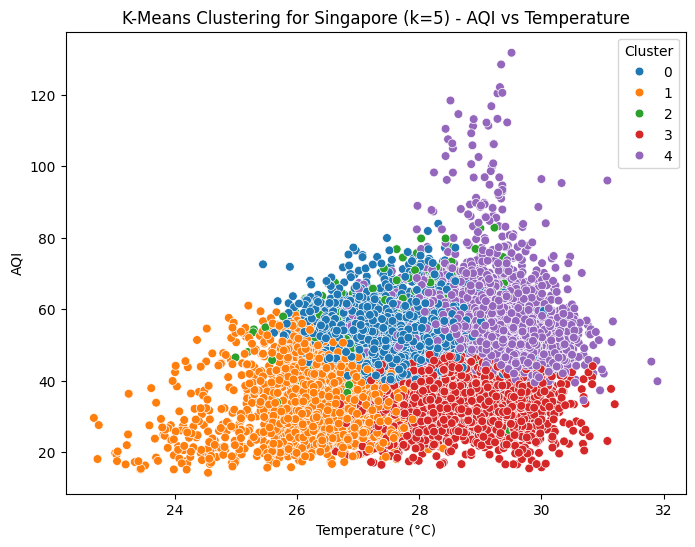


K-Means Clustering for: Thailand


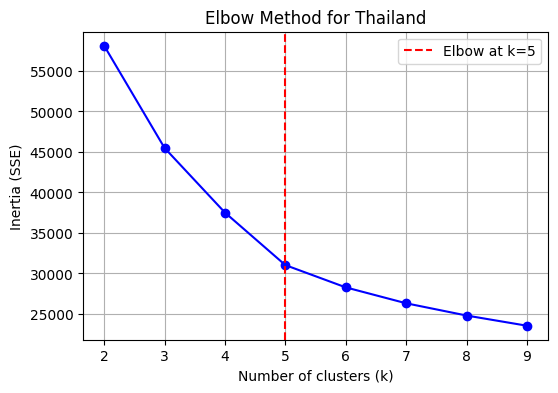


Final Silhouette Score for Thailand: 0.296
Inertia (SSE): 31025.75
Largest cluster size ratio: 35.12%

Cluster counts:
Cluster
1    6447
3    4010
4    3377
2    2398
0    2125
Name: count, dtype: int64

Average values per cluster:
                AQI  Temperature  RelativeHumidity  WindSpeed
Cluster                                                      
0        159.512706    22.982080         64.333304   7.134838
1        148.635726    27.009045         82.768961   6.047534
2        177.320046    29.339012         57.303353   7.582769
3        138.016682    28.370569         75.062813  13.194783
4         45.098256    27.778573         79.022209   8.625840


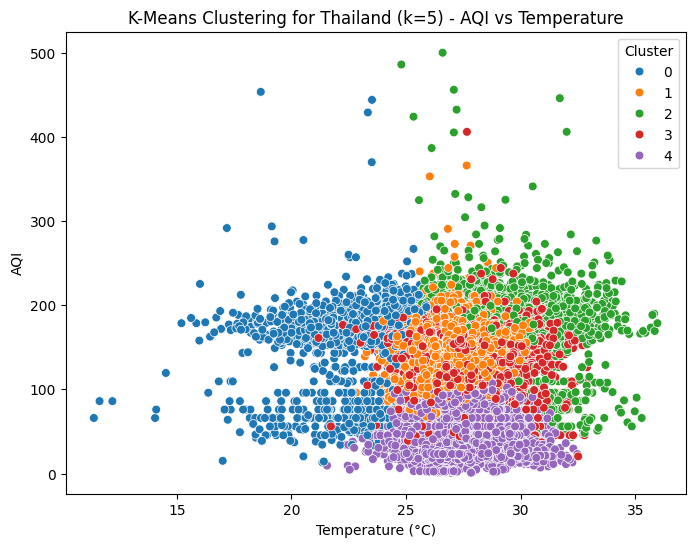

In [8]:
# Cluster each country separately
all_results = []
summary = []  # for storing model evaluation summary

for country, group in df.groupby("Country"):
    print(f"\n============================")
    print(f"K-Means Clustering for: {country}")
    print("============================")

    # Drop missing values
    group = group.dropna(subset=['AQI', 'Temperature', 'RelativeHumidity', 'WindSpeed'])

    # Select features
    X = group[['AQI', 'Temperature', 'RelativeHumidity', 'WindSpeed']].values

    # Normalize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Find best k using Elbow Method (Inertia)
    sil_scores = []
    inertia_values = []
    K = range(2, 10)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        inertia_values.append(kmeans.inertia_)
        score = silhouette_score(X_scaled, labels)
        sil_scores.append(score)

    # --- Detect elbow point automatically
    knee = KneeLocator(K, inertia_values, curve='convex', direction='decreasing')
    best_k = knee.knee


    # --- Plot Elbow (Inertia)
    plt.figure(figsize=(6, 4))
    plt.plot(K, inertia_values, 'bo-')
    if best_k is not None:
        plt.axvline(best_k, color='r', linestyle='--', label=f'Elbow at k={best_k}')
    plt.title(f'Elbow Method for {country}')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia (SSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------------------
    # K-Means Clustering
    # ----------------------------------
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    group['Cluster'] = kmeans.fit_predict(X_scaled)

    # Evaluation metrics
    final_silhouette = silhouette_score(X_scaled, group['Cluster'])
    final_inertia = kmeans.inertia_

    cluster_counts = group['Cluster'].value_counts()
    largest_cluster_ratio = cluster_counts.max() / len(group)

    print(f"\nFinal Silhouette Score for {country}: {final_silhouette:.3f}")
    print(f"Inertia (SSE): {final_inertia:.2f}")
    print(f"Largest cluster size ratio: {largest_cluster_ratio:.2%}")

    # Cluster summary
    print("\nCluster counts:")
    print(cluster_counts)

    print("\nAverage values per cluster:")
    print(group.groupby('Cluster')[['AQI', 'Temperature', 'RelativeHumidity', 'WindSpeed']].mean())

    # ----------------------------------
    # Visualization
    # ----------------------------------
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=group, x='Temperature', y='AQI', hue='Cluster', palette='tab10', s=40)
    plt.title(f"K-Means Clustering for {country} (k={best_k}) - AQI vs Temperature")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("AQI")
    plt.legend(title="Cluster")
    plt.show()